In [37]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import os
import pandas as pd
import librosa
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
working_folder_path = "/content/drive/MyDrive/3YP/"

In [3]:
raw_data = pd.read_pickle(working_folder_path+"Res/df_10000_sp_random.pkl")

images = np.load(working_folder_path + "Res/image_list.npy")
parameters = np.zeros([raw_data["audio"].size, 281])

for i in range(raw_data["audio"].size):
    param = raw_data["param"][i].all()
    parameters[i, :] = list(param.values())

In [ ]:
# Check Parameter Varience
non_constant_param_indices = np.where(np.std(parameters, axis=0) > 1e-5)[0]
print(non_constant_param_indices, non_constant_param_indices.shape)
non_constant_param = parameters[:, non_constant_param_indices]
print(non_constant_param[2233], non_constant_param.shape)

In [12]:
# Flatten and standardize images
flattened_images = images.reshape(images.shape[0], -1)
standardized_images = StandardScaler().fit_transform(flattened_images)


(10000, 50176)
(50176,)


In [75]:
# Perform PCA
pca = PCA(256)
pca_images = pca.fit_transform(standardized_images)

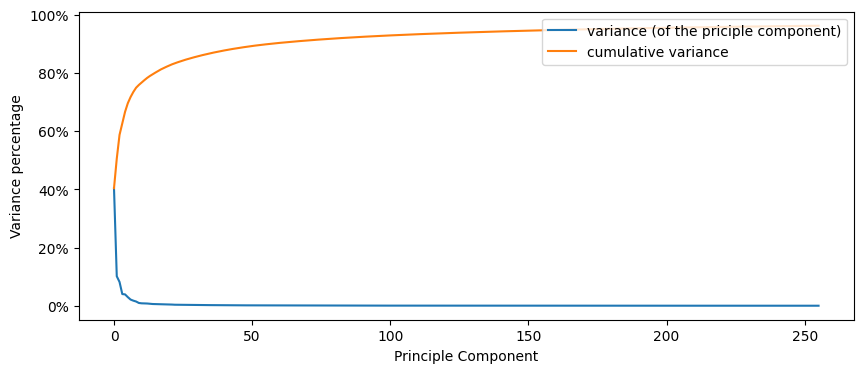

In [97]:
import matplotlib.ticker as mtick

variance_ratios = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratios)
# print("Cumulative explained variance:", cumulative_explained_variance)
plt.figure(figsize=(10, 4))
plt.ylabel("Variance percentage")
plt.xlabel("Principle Component")
plt.plot(variance_ratios, label="variance (of the priciple component)")
plt.plot(cumulative_variance, label="cumulative variance")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.legend(loc="upper right")
plt.savefig(working_folder_path+'figures/PCA256var.eps')
plt.show()


In [39]:
print(pca_images.shape)
non_constant_pca_images_indices = np.where(np.std(pca_images, axis=0) != 0)[0]
print(non_constant_pca_images_indices, non_constant_pca_images_indices.shape)

(10000, 128)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127] (128,)


In [70]:
# Calculate correlations between input parameters and PCs
num_parameters = non_constant_param.shape[1]
num_pcs = pca_images.shape[1]
correlations = np.zeros((num_parameters, num_pcs))
param_const_idx = []
# Calculate correlations between input parameters and PCs
num_parameters = non_constant_param.shape[1]
num_pcs = pca_images.shape[1]
correlations = np.zeros((num_parameters, num_pcs))

for i in range(num_parameters):
    for j in range(num_pcs):
        if not (np.isnan(non_constant_param[:, i]).any() or np.isinf(non_constant_param[:, i]).any() or
                np.isnan(pca_images[:, j]).any() or np.isinf(pca_images[:, j]).any()):
            correlations[i, j] = pearsonr(non_constant_param[:, i], pca_images[:, j])[0]
        else:
            correlations[i, j] = np.nan  # Set correlation to NaN if either parameter or PCA image contains NaN or infinite values

correlations = np.abs(correlations.T)


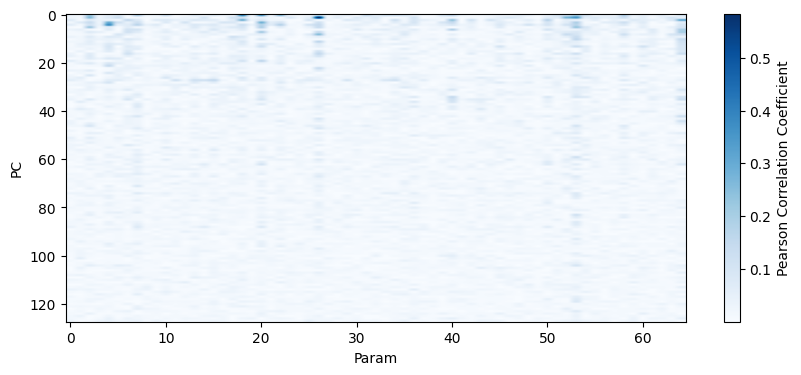

In [96]:

plt.figure(figsize=(10, 4))
plt.xlabel("Param")
plt.ylabel("PC")

plt.imshow(correlations, aspect='auto', cmap='Blues')
bar = plt.colorbar()
bar.set_label('Pearson Correlation Coefficient')
# Get the current reference
ax = plt.gca()


plt.savefig(working_folder_path+'figures/PCA256-PCC.eps')
plt.show()

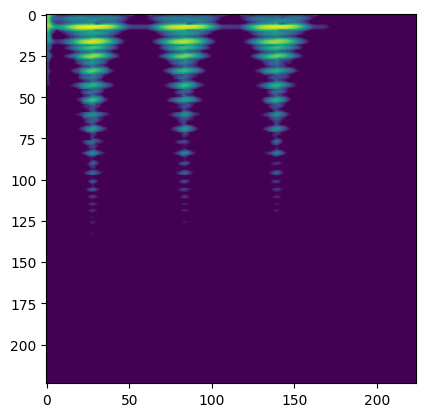

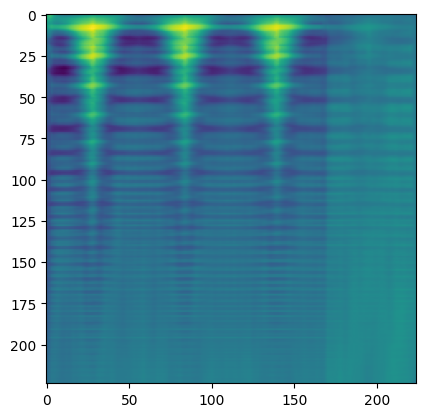

In [55]:
img0_pc = pca_images[0, :]
img0_reconstructed = pca.inverse_transform(img0_pc)
img0_reconstructed = img0_reconstructed.reshape(224, 224)
plt.figure()
plt.imshow(images[0,::].reshape(224, 224))
plt.figure()
plt.imshow(img0_reconstructed)

In [100]:
correlations_eval = np.sum(np.abs(correlations), axis=0)
top_indices = np.argsort(correlations_eval)[-32:][::-1]
top_param = []
keys_lst = list(param.keys())
for index in top_indices:
    if correlations_eval[index] != 0:
        top_param.append(keys_lst[index])
top_param

['LFO1: DepthMod Src1',
 'Plate2: Dry',
 'LFO1: Delay',
 'ENV2: Attack',
 'Scope1: Frequency',
 'OSC: PulseShape',
 'Rtary2: Mode',
 'ENV2: Curve',
 'MOD: MulSource1',
 'OSC: EcoWave2',
 'Delay1: Center Vol',
 'OSC: ShapeModOsc3',
 'VCF1: SvfMode',
 'Rtary1: Slow',
 'Phase2: Wet',
 'main: Active #FX1',
 'ENV1: Decay',
 'Delay2: HP',
 'OSC: Volume3',
 'Delay1: Left Delay',
 'ENV2: Model',
 'HPF: Post-HPF Freq',
 'PCore: LED Colour',
 'VCF1: Resonance',
 'OSC: NoiseVolModDepth',
 'VCA1: ModDepth',
 'HPF: FreqModSrc',
 'Rtary2: Slow',
 'OSC: NoiseColor',
 'LFO2: Phase',
 'HPF: KeyFollow',
 'HPF: FreqModDepth']

In [74]:
top_param

['Delay1: Center Vol',
 'Delay1: Left Delay',
 'Delay2: HP',
 'ENV1: Decay',
 'ENV2: Attack',
 'ENV2: Curve',
 'ENV2: Model',
 'HPF: FreqModDepth',
 'HPF: FreqModSrc',
 'HPF: KeyFollow',
 'HPF: Post-HPF Freq',
 'LFO1: Delay',
 'LFO1: DepthMod Src1',
 'LFO2: Phase',
 'MOD: MulSource1',
 'OSC: EcoWave2',
 'OSC: NoiseColor',
 'OSC: NoiseVolModDepth',
 'OSC: PulseShape',
 'OSC: ShapeModOsc3',
 'OSC: Volume3',
 'PCore: LED Colour',
 'Phase2: Wet',
 'Plate2: Dry',
 'Rtary1: Slow',
 'Rtary2: Mode',
 'Rtary2: Slow',
 'Scope1: Frequency',
 'VCA1: ModDepth',
 'VCF1: Resonance',
 'VCF1: SvfMode',
 'main: Active #FX1']